### They inner atoms, and the outer atoms are equally spaced

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import matplotlib.animation as animation
import os

In [5]:
save_path = r'C:\Users\Leopold\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Plots\Qutip'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [11]:
fixed_lam = 1
fixed_gamma = 1

fixed_dist_in  = 1  * fixed_lam
fixed_dist_ext  = 1  * fixed_lam
fixed_phi  = 0
fixed_d_hat = np.array([1, 1, 1]) / np.sqrt(3) ### not needed?
########################################                 Define constants                   #############################################
N = 6

x_0    = 0.2
x_max  = 1.5

phi_0    = 0
phi_max  = 2 * np.pi / 3

phi_size = 30
x_size   = 100

########################################################################################################################    
phis   = np.linspace(phi_0, phi_max, phi_size)
dists  = np.linspace(x_0, x_max, x_size) * fixed_lam

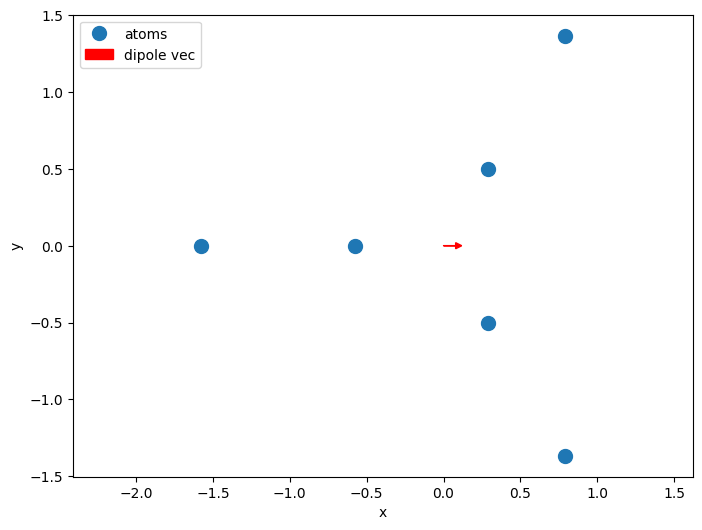

In [7]:
########################################               define the geometry                 #############################################
def dipole_vector(phi = fixed_phi):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.cos(phi), np.sin(phi), 0])
    return dipole

def atom_positions(d_in = fixed_dist_in, d_ext = fixed_dist_ext, N = N):
    """ Returns     np.ndarray: Positions of the six atoms as a Nx3 array. """
    Pos = np.zeros((N, 3))

    # Calculate the inner triangle vertices (atoms 2, 3, 4)
    cos = np.cos(2 * np.pi / 6) # 60 degrees in radians
    sin = np.sin(2 * np.pi / 6) # 60 degrees in radians
    x = d_in / (2 * np.cos(np.pi / 6)) # 30 deg
    Pos[0] = (- x, 0, 0)
    Pos[1] = (+ x * cos, + x * sin, 0)
    Pos[2] = (+ x * cos, - x * sin, 0)

    for i in range((N-1) // 3):
        Pos[3 * (i+1)] = Pos[0]     + (- (i+1) * d_ext, 0, 0)
        Pos[3 * (i+1) + 1] = Pos[1] + (+ (i+1) * d_ext * cos, + (i+1) * d_ext * sin, 0)
        Pos[3 * (i+1) + 2] = Pos[2] + (+ (i+1) * d_ext * cos, - (i+1) * d_ext * sin, 0)
    Pos_sorted = Pos[Pos[:, 0].argsort()]

    return Pos_sorted

positions = atom_positions(fixed_dist_in, fixed_dist_in)
#print(positions)
d_hat = dipole_vector()
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
# Plot the atom positions
plt.figure(figsize=(8, 6))
plt.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
plt.arrow(0, 0, d_hat[0] * scale, d_hat[1] * scale, 
          head_width=0.5*scale, head_length=0.5*scale, fc='r', ec='r', label='dipole vec')
# Plot dipole vectors
#for i, position in enumerate(positions):
#    plt.arrow(position[0], position[1], d_hat[0] * scale, d_hat[1] * scale, 
#              head_width=0.2*scale, head_length=0.2*scale, fc='r', ec='r')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.show()

In [8]:
########################################             create the Hamiltonean                 ################################################# old version also down at the bottom
#implement the Greenstensor, not really needed????, just for the different orientations of the dipole vectors
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    Greenstensor = (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))
    return Greenstensor

def Gamma_coefficients(r_a, r_b,
                       d_a = dipole_vector(), 
                       d_b = dipole_vector(),
                       lam = fixed_lam,
                       gamma = fixed_gamma) -> float:

    if np.linalg.norm(r_b - r_a) < 1e-5:
        return gamma
    k_a = 2 * np.pi / lam
    result = (6 * np.pi * gamma / k_a  # also / d^2 but it has length 1
              * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
    return np.imag(result)

def V_coefficients(r_a, r_b,
                   d_a = dipole_vector(), 
                   d_b = dipole_vector(),
                   lam = fixed_lam,
                   gamma = fixed_gamma) -> float:
    
    if np.linalg.norm(r_b - r_a) < 1e-5:
        return 0
    k_a = 2 * np.pi / lam
    result = (-3 * np.pi * gamma / k_a # also / d^2 but it has length 1
              * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
    return np.real(result)

def H_eff(distance_in: float = fixed_dist_in,
          distance_ext: float = fixed_dist_ext,
          d_a = dipole_vector(), 
          d_b = dipole_vector(),
          lam = fixed_lam,
          gamma: float = fixed_gamma,
          N: int = N):
    
    positions  = atom_positions(distance_in, distance_ext)
    H_eff_matrix = np.zeros((N, N), dtype=complex)

    for a in range(N):
        for b in range(N):
            r_a = positions[a]
            r_b = positions[b]

            V_ab = V_coefficients(r_a, r_b, d_a, d_b, lam, gamma)
            Gamma_ab = Gamma_coefficients(r_a, r_b, d_a, d_b, lam, gamma)

            matrix_element = V_ab - 1j * 0.5 * Gamma_ab
            H_eff_matrix[a, b] = matrix_element
    return Qobj(H_eff_matrix)
H = H_eff_test()
H

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.        -0.5j        -0.00604716+0.03799544j -0.00064916+0.01036299j
  -0.00064916+0.01036299j  0.0044114 +0.01067949j  0.0044114 +0.01067949j]
 [-0.00604716+0.03799544j  0.        -0.5j        -0.03362103+0.02374715j
  -0.03362103+0.02374715j -0.02723902+0.01523052j -0.02723902+0.01523052j]
 [-0.00064916+0.01036299j -0.03362103+0.02374715j  0.        -0.5j
  -0.11634263-0.01899772j -0.08876876-0.00474943j -0.05382888+0.02009805j]
 [-0.00064916+0.01036299j -0.03362103+0.02374715j -0.11634263-0.01899772j
   0.        -0.5j        -0.05382888+0.02009805j -0.08876876-0.00474943j]
 [ 0.0044114 +0.01067949j -0.02723902+0.01523052j -0.08876876-0.00474943j
  -0.05382888+0.02009805j  0.        -0.5j         0.00237123+0.04355261j]
 [ 0.0044114 +0.01067949j -0.02723902+0.01523052j -0.05382888+0.02009805j
  -0.08876876-0.00474943j  0.00237123+0.04355261j  0.        -0.5j       ]]

In [9]:
################ TRY to get the Wave-packet
# Annahmen über N und a
k_s = np.pi / fixed_dist_ext
sigma = 0.103 * k_s
wp_sh = 1 / 4

kd_range = np.arange(0, N) * 2 * np.pi / N

def calc_T() -> np.ndarray:
    T_temp = np.zeros((N, N), dtype=complex)
    for i in range(kd_range.size):
        T_temp[:, i] = np.exp(1j * np.arange(0, N) * kd_range[i])

    return 1 / np.sqrt(N) * T_temp

def psi0_reziprokal_ps():
    gaussian_state_rs = np.exp(-(kd_range - k_s) ** 2 / (4 * sigma ** 2))
    gaussian_state_rs = gaussian_state_rs / np.sqrt(np.vdot(gaussian_state_rs, gaussian_state_rs))
    wp_shift = np.exp(-2j * wp_sh * np.pi * np.arange(N))
    psi0 = np.matmul(calc_T(), wp_shift * gaussian_state_rs)

    return Qobj(psi0[:, np.newaxis])  # Konvertiere zu einem Spaltenvektor
psi0 = psi0_reziprokal_ps()
psi0

Quantum object: dims=[[6], [1]], shape=(6, 1), type='ket', dtype=Dense
Qobj data =
[[2.36876317e-11+0.40607139j]
 [2.36876280e-11-0.45739964j]
 [2.36876662e-11+0.45739964j]
 [2.36876317e-11-0.40607139j]
 [2.36876805e-11+0.35481206j]
 [2.36875556e-11-0.35481206j]]

In [ ]:
def total_phases(distances, phis, N = N):
    total_ps = np.zeros((len(distances), len(phis)))
    for i, distance in enumerate(tqdm(distances, desc='Iteration')):
        for j, phi in enumerate(phis):
            dist_in = distance
            dist_ext = 0.10 * dist_in
            H = H_eff_red(dist_in, dist_ext, phi = phi)
            p = (np.angle(H[N//3 - 1, N//3]) +
                 np.angle(H[N//3 - 1, N//3+1]) +
                 np.angle(H[N//3, N//3+1])) / np.pi
            total_ps[i, j] = p
    return total_ps

phases = total_phases(dists, phis)

In [ ]:
# Create the animation
fig, ax = plt.subplots()
line, = ax.plot(dists, phases[:, 0])

def update(frame):
    line.set_ydata(phases[:, frame])
    ax.set_title(f'angle of dipole vec: phi = {phis[frame]:.2f}')
    ax.set_xlabel(f'total phase along the loop ')
    ax.set_ylabel(f'distance x / lambda')
    return line,

ani = animation.FuncAnimation(fig, update, frames=len(phis), blit=True)

# Save the animation as a GIF or MP4 file
save_path = r'C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Plots\Qutip\phases_vs_distance_for_different_dipoles_.gif'
ani.save(save_path, writer='pillow')
a
# Show the animation
plt.show()

In [ ]:
# plot phi(distances for a dipole orientation)
fig, ax = plt.subplots()
plt.plot(dists, phases, label=r'total Phase/ $\pi$')
plt.xlabel(r'distance x')
plt.ylabel(r'Phase / $\pi$')
plt.title(f'Phase of off-diagonal entries of H over distance for $\phi$')#={fixed_phi:.2f}
#plt.legend()
plt.show()

In [ ]:
d = 1.0
k_s = np.pi  / d # devide by the real distance!!!!!!!
sigma = 0.1 * k_s

# Discrete k-space values
kd_range = np.arange(0, N) * 2 * np.pi / N

# Gaussian wave packet in k-space
f_k = np.exp(-(kd_range - k_s)**2 / (4 * sigma**2)) / np.sqrt(np.sqrt(2 * np.pi) * sigma)

# Initial state in k-space
basis_states = [basis(N, i) for i in range(N)]
psi_k = sum(f * state for f, state in zip(f_k, basis_states))

# Fourier transform to real space
x_alpha = atom_positions()
psi_x = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.sum([np.exp(-1j * k_s * x) * np.exp(-sigma**2 * x**2) * state for x, state in zip(x_alpha, basis_states)], axis=0)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Plot Gaussian in k-space
axs[0].plot(kd_range, f_k.real, label='Real part')
axs[0].plot(kd_range, f_k.imag, label='Imaginary part')
axs[0].set_title("Gaussian Wave Packet in k-space")
axs[0].set_xlabel("k")
axs[0].set_ylabel("Amplitude")
axs[0].legend()

# Plot Gaussian in real space
axs[1].plot(x_alpha, np.abs(psi_x.full().flatten()), label='Magnitude')
axs[1].set_title("Gaussian Wave Packet in Real Space")
axs[1].set_xlabel("x")
axs[1].set_ylabel("Amplitude")
axs[1].legend()

plt.tight_layout()
plt.show()

# old implementation

In [34]:
########################################             create the Hamiltonean                 ################################################# old version
#jetzt direkter weg zur NxN matrix
def H_eff(N: int,
          distance_in: float = fixed_dist_in, 
          distance_ext: float = fixed_dist_ext, 
          phi: float = fixed_phi,
          gamma: float = fixed_gamma):

    d_hat = dipole_vector(phi)
    H_eff_matrix = np.zeros((N, N), dtype=complex)
    pos = atom_positions(distance_in, distance_ext, N)

    for i in range(N):
        for j in range(N):
            V_ij = 0
            if i == j:
                Gamma_ij = gamma
            else:
                r_ij = pos[j] - pos[i]
                x = np.linalg.norm(r_ij)
                r_hat_ij = r_ij / x
                k = 2 * np.pi * x
                dot_ij = np.dot(d_hat, r_hat_ij)

                Gamma_ij = 3/2 * gamma * ((1 - (dot_ij)**2) * np.sin(k) / k +
                                          (1 - 3 * (dot_ij)**2) * (np.cos(k)/k**2 -
                                                                   np.sin(k) / k**3))

                V_ij = - 3/4 * gamma * ((1 - (dot_ij)**2) * np.cos(k) / k -
                                        (1 - 3 * (dot_ij)**2) * (np.sin(k)/k**2 +
                                                                 np.cos(k) / k**3))

            matrix_element = V_ij - 1j * 0.5 * Gamma_ij
            H_eff_matrix[i, j] = matrix_element
            
#            self._Gamma = matrix_element.imag  ???????
    return Qobj(H_eff_matrix)
H_ex = H_eff(N)
H_ex

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.        -0.5j        -0.00604716+0.03799544j -0.00064916+0.01036299j
  -0.00064916+0.01036299j  0.0044114 +0.01067949j  0.0044114 +0.01067949j]
 [-0.00604716+0.03799544j  0.        -0.5j        -0.03362103+0.02374715j
  -0.03362103+0.02374715j -0.02723902+0.01523052j -0.02723902+0.01523052j]
 [-0.00064916+0.01036299j -0.03362103+0.02374715j  0.        -0.5j
  -0.11634263-0.01899772j -0.08876876-0.00474943j -0.05382888+0.02009805j]
 [-0.00064916+0.01036299j -0.03362103+0.02374715j -0.11634263-0.01899772j
   0.        -0.5j        -0.05382888+0.02009805j -0.08876876-0.00474943j]
 [ 0.0044114 +0.01067949j -0.02723902+0.01523052j -0.08876876-0.00474943j
  -0.05382888+0.02009805j  0.        -0.5j         0.00237123+0.04355261j]
 [ 0.0044114 +0.01067949j -0.02723902+0.01523052j -0.05382888+0.02009805j
  -0.08876876-0.00474943j  0.00237123+0.04355261j  0.        -0.5j       ]]

In [ ]:
'''def ladder_operator(i, operator_type, N = N):
    if i <= 0 or i > N:
        raise ValueError("Index i out of range. Use 1 <= i <= N")
    if operator_type not in ['lowering', 'raising']:
        raise ValueError("Invalid operator type. Use 'lowering' or 'raising'.")
    if operator_type == 'lowering':
        op_atom = destroy(2)  # Outer product |g⟩⟨e| = ((0,1), (0,0))
    else:
        op_atom = create(2)  # Outer product |e⟩⟨g| = ((0,0), (1,0))
    identity_list = [qeye(2) for _ in range(N)]
    identity_list[i - 1] = op_atom
    op = tensor(identity_list)
    return op

def single_excitation_basis(N = N):
    basis_states = []
    for i in range(N):
        state_list = [basis(2, 0)] * N
        state_list[i] = basis(2, 1)
        basis_state = tensor(state_list)
        basis_states.append(basis_state)
    return basis_states

def generic_superposition(basis_states, coefficients=None):
    N = len(basis_states)
    if coefficients is None:
        coefficients = np.random.rand(N) + 1j * np.random.rand(N)
        coefficients /= np.linalg.norm(coefficients)
    
    superposition = sum(c * state for c, state in zip(coefficients, basis_states))
    return superposition.unit()

def H_eff(distance_in: float = fixed_dist_in,
          distance_ext: float = fixed_dist_ext,
          phi: float = fixed_phi,
          gamma: float = fixed_gamma,
          N: int = N):

    d_hat = dipole_vector(phi)
    pos = atom_positions(distance_in, distance_ext)
    H_V = 0
    H_Gamma = 0
    for i in range(N):
        for j in range(N):
            V_ij = 0
            if i == j:
                Gamma_ij = gamma
            else:
                r_ij = pos[j] - pos[i]
                x = np.linalg.norm(r_ij)
                r_hat_ij = r_ij / x
                k = 2 * np.pi * x
                dot_ij = np.dot(d_hat, r_hat_ij)

                Gamma_ij = 3/2 * gamma * ((1 - (dot_ij)**2) * np.sin(k) / k +
                                          (1 - 3 * (dot_ij)**2) * (np.cos(k)/k**2 -
                                                                   np.sin(k) / k**3))

                V_ij = - 3/4 * gamma * ((1 - (dot_ij)**2) * np.cos(k) / k -
                                        (1 - 3 * (dot_ij)**2) * (np.sin(k)/k**2 +
                                                                 np.cos(k) / k**3))
                
            raising_op_i  = ladder_operator(i+1, 'raising')
            lowering_op_j = ladder_operator(j+1, 'lowering')
                
            H_Gamma += Gamma_ij * (raising_op_i * lowering_op_j)
            H_V     += V_ij     * (raising_op_i * lowering_op_j)

    return H_V - 1/2 * 1j * H_Gamma

def H_eff_red(distance_in: float = fixed_dist_in,
              distance_ext: float = fixed_dist_ext,
              phi: float = fixed_phi,
              gamma: float = fixed_gamma,
              N: int = N):
    
    H = H_eff(distance_in, distance_ext, phi, gamma, N)
    single_exc_basis = single_excitation_basis(N)
    H_reduced = np.zeros((N, N), dtype=complex)

    for i, bra in enumerate(single_exc_basis):
        for j, ket in enumerate(single_exc_basis):
            H_reduced[i, j] = H.matrix_element(bra.dag(), ket)

    return Qobj(H_reduced)
# example form of the Hamiltonean
H_red_ex = H_eff_red()
H_red_ex'''